## M6W8 Assignment: Deep Learning II

Deep learning is a subfield of machine learning, growing in popularity and power. The combination of a large amount of available unstructured data (images, text, video, audio) and computing power enabled the development and flourishing of deep learning. Nowadays, it is used to solve complex problems and automate tasks, which are too time consuming for humans.

The MNIST dataset is a very famous dataset used to test and benchmark new deep learning architectures and models. It contains images of handwritten digits (from 0 to 9). It consists of a training and test sets of features and labels.

My first task is to use Keras and develop a model that correctly detects a handwritten digit; this is a multi-class classification task.

I will then evaluate my model properly and interpret its performance.

I will be working with a version of the MNIST dataset that can be found here:

https://www.kaggle.com/oddrationale/mnist-in-csv

You can refer to Yann LeCun’s website for the raw data of MNIST, as well as some classifiers developed to correctly classify the images of handwritten images:

http://yann.lecun.com/exdb/mnist/

In [13]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.utils import to_categorical
import random

In [2]:
#Import the train and test datasets
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')

In [3]:
print(train.head(10))
print(test.head())
print(train.label.value_counts().sort_index())
print('Train dataset contains', train.shape[0], 'rows\n')
print('Test dataset contains', test.shape[0], 'rows')

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   
5      2    0    0    0    0    0    0    0    0    0  ...      0      0   
6      1    0    0    0    0    0    0    0    0    0  ...      0      0   
7      3    0    0    0    0    0    0    0    0    0  ...      0      0   
8      1    0    0    0    0    0    0    0    0    0  ...      0      0   
9      4    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0

Both the train and test sets contain 785 columns with the first column `label` relating to the number that the array relates to, and the remaining columns giving the pixel value in a 28x28 image.

The labels indicate that the data contains images of digits from `0` through to `9`.

The training dataset contains 60,000 images, and the test contains 10,000.

In [4]:
print('Train dataset missing values: \n', train.isnull().sum().loc[lambda x : x>0].sort_values(ascending=False), '\n')
print('Test dataset missing values: \n', test.isnull().sum().loc[lambda x : x>0].sort_values(ascending=False), '\n')

Train dataset missing values: 
 Series([], dtype: int64) 

Test dataset missing values: 
 Series([], dtype: int64) 



We can see from the above that there are no missing values. Next let's pick some random lines from the `train` dataset and check if the images match the `label` column.

Number 7


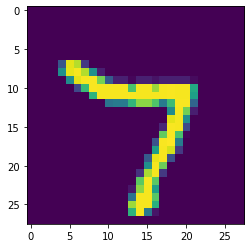

Number 3


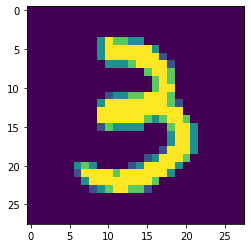

Number 8


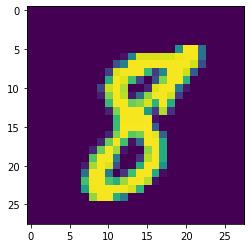

Number 9


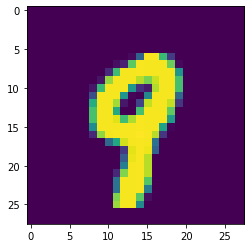

Number 3


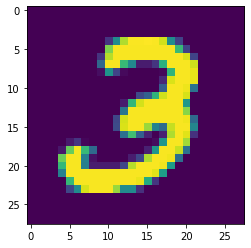

In [5]:
#Select a random sample of 5 rows
sample = train.sample(5, random_state=42)

#loop over rows in sample and display number and corresponding image
for index, row in sample.iterrows():
    print('Number', row['label'])
    img_data = row.drop('label')
    img_array = img_data.values.reshape(28, 28)
    plt.imshow(img_array)
    plt.show()

It can be seen from the sample of 5 above that the number matches the image.

Let's set up the training and test datasets, and then train a multi-class classification model. I will use `to_categorical` to make the labels compatible with the model. This is to ensure that each example has an expected probability of 1.0 for the actual class value and an expected probability of 0.0 for all other class values

In addition, I will convert the 1D array of image data into a 28x28 matrix ready for the model as well as normalise the numbers in the input data to be `floats` that sit between `0` and `1`.

In [6]:
X_train = train.drop('label', axis=1)
X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)
y_train = train['label']
y_train = to_categorical(y_train)
X_test = test.drop('label', axis=1)
X_test = X_test.to_numpy().reshape(-1, 28, 28, 1)
y_test = test['label']
y_test = to_categorical(y_test)

#Convert values to `float32`
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#Convert values to between 0 and 1 
#Divide by 255 as that is the range of integers used to represent greyscale
X_train = X_train / 255.
X_test = X_test / 255.

print('X_train shape:' , X_train.shape, '\n')
print('y_train shape:' , y_train.shape, '\n')
print('X_test shape:' , X_test.shape, '\n')
print('y_test shape:' , y_test.shape, '\n')

X_train shape: (60000, 28, 28, 1) 

y_train shape: (60000, 10) 

X_test shape: (10000, 28, 28, 1) 

y_test shape: (10000, 10) 



We can now see that the image data is a 28x28 matrix, and the labels are now a one-hot encoded array of 10 classes.

Next let's build a model using the following layers:

`Conv2D` - Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel (a convolution matrix or masks which can be used for blurring, sharpening, embossing, edge detection, and more by doing a convolution between a kernel and an image) that helps produce a tensor of outputs. 

`LeakyRelu` - Helps the network learn non-linear decision boundaries. Since I have ten different classes, we'll need a non-linear decision boundary that could separate these ten classes which are not linearly separable.

`MaxPooling2D` - Max pooling reduces the dimensionality of images by reducing the number of pixels in the output from the previous convolutional layer. This reduces computational load as well as reducing over-fitting.

`Flatten` - Passes the flattened output to the output layer where I will use a softmax classifier to predict the input class label.

The output layer has 10 nodes to match the number of classes (`0` to `9`) and `softmax` as its activation as this is a mutlticlass classification problem.

In [7]:
#First define a function for the model

def digit_model(learning_rate):
    """
    Keras Multi-layer neural network. Set parameters are:
    
    Use adam as the optimizer
    Softmax as the output activation
    categorical_crossentropy for loss
    
    Parameters
    ----------
    Tunable parameters are:
    
    batch size
    learning rate
    epochs
    
    Returns
    -------
    model : 
        a keras model   
    """   
    #Use Adam optimiser using defined learning rate
    opt = Adam(lr = learning_rate)
    
    #Build multi-class model with input to match number of pixels
    #Conv2D is best for image recognition
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))                  
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))   
        
    #Add output layer with 10 outputs (one for each digit) using softmax
    model.add(Dense(10, activation='softmax'))
    
    #Compile model using categorical_crossentropy, above optimiser, and accuracy as metric
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
#Next build Kerasclassifier to use to tune hyper parameters
model_keras = KerasClassifier(build_fn = digit_model)

#Define parameters to test
params = {'batch_size': [32, 64, 128],
          'learning_rate': [0.1, 0.01, 0.001],
          'epochs': [6, 12, 18]}

In [9]:
#Use RandomizedSearchCV to test params given above
#Reduced n_iters which will mean lower quality, but faster runtime
rs_digits = RandomizedSearchCV(
    model_keras,
    param_distributions = params,
    cv = 5,
    n_jobs = -1,
    n_iter = 3,
    verbose = 1
)

In [10]:
#Fit to training data and see best paramters
#Validate using test dataset
rs_results = rs_digits.fit(X_train, y_train, validation_data=(X_test, y_test))

#Display best scores and parameters
print('Best score:', rs_results.best_score_)
print('Parameters:', rs_results.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 217.3min finished


Epoch 1/6
938/938 [==============================] - 103s 109ms/step - loss: 0.1445 - accuracy: 0.9555 - val_loss: 0.0318 - val_accuracy: 0.9894
Epoch 2/6
938/938 [==============================] - 100s 106ms/step - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.0339 - val_accuracy: 0.9883
Epoch 3/6
938/938 [==============================] - 101s 108ms/step - loss: 0.0268 - accuracy: 0.9916 - val_loss: 0.0281 - val_accuracy: 0.9912
Epoch 4/6
938/938 [==============================] - 101s 107ms/step - loss: 0.0199 - accuracy: 0.9938 - val_loss: 0.0289 - val_accuracy: 0.9912
Epoch 5/6
938/938 [==============================] - 101s 108ms/step - loss: 0.0152 - accuracy: 0.9957 - val_loss: 0.0384 - val_accuracy: 0.9875
Epoch 6/6
938/938 [==============================] - 102s 109ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0403 - val_accuracy: 0.9887
Best score: 0.988616669178009
Parameters: {'learning_rate': 0.001, 'epochs': 6, 'batch_size': 64}


## Summary

From the above we can see the accuracy on the training data improve with each epoch and the validation accuracy goes up and then down again very slightly. The loss on the training data also improves while the loss on the validation (test) data improves and then worsens again. This suggests that the model may be starting to slightly overfit after 3 epochs, though this would need further investigation.

The `loss` is calculated using `categorical_crossentropy` and calculates a score that summarises the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.

The `accuracy` is simply the number of correct predictions over the size of the dataset. So we can see with the test (validation) data it was correct 98.87% of the time.

Worth noting that this level accuracy was from the parameters shown above in the results, and using RandomizedSearch with `n_iter` set to 3. Using a GridSearchCV or a higher `n_iter` may have seen a further increase in accuracy.

Next let's look at the predications and see how they fare against the actual numbers from a random sample of 5.

In [26]:
y_pred = rs_digits.predict(X_test)
random.seed(42)
for i in random.sample(range(0, len(X_test)), 5):
    actual = np.argmax(y_test[i], axis=-1)
    pred = y_pred[i]
    print('Actual:', actual, 'Prediction:', pred)

Actual: 2 Prediction: 2
Actual: 1 Prediction: 1
Actual: 2 Prediction: 2
Actual: 4 Prediction: 4
Actual: 6 Prediction: 6


We can see from the sample of 5 that the model accurately predicts the digit.

## Further work

Due to the constraints of the hardware available to me I have been limited in what I could tune the model for, as well as the number of models to test. I would like to further investigate tuning the following parameters and hyperparameters:

1) Activation
2) Optimisers and their parameters
3) Number of layers
4) Number of neurons
5) Types of layers

I would also use `EarlyStopping()` to better tune the number of epochs.

I believe the above would bring the model closer to an accuracy of 1.